In [1]:
# Core Imports and Functions
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from scipy.ndimage import label
from tqdm import tqdm

# Configuration Parameters
DIM = 3  # Base dimension
POWER = 4  # Lattice size = DIM^POWER
MAX_STEPS = POWER + 5  # Maximum coarse-graining steps

def generate_percolation_lattice(size, p):
    return np.random.choice([0, 1], (size, size), p=[1-p, p])

def check_percolation(lattice):
    labeled, _ = label(lattice)
    
    # Vertical percolation (top-bottom)
    top = set(labeled[0, :]) - {0}
    bottom = set(labeled[-1, :]) - {0}
    vertical = bool(top & bottom)
    
    # Horizontal percolation (left-right)
    left = set(labeled[:, 0]) - {0}
    right = set(labeled[:, -1]) - {0}
    horizontal = bool(left & right)
    
    return float(vertical or horizontal)


class PercolationModel(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.rule = nn.Sequential(
            nn.Linear(dim*dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, max_steps=MAX_STEPS):
        b, c, H, W = x.shape
        
        for _ in range(max_steps):
            if H < self.dim or W < self.dim: break
            
            # Extract dimxdim patches
            patches = F.unfold(x, kernel_size=self.dim, stride=self.dim)
            patches = patches.permute(0, 2, 1).contiguous()
            patches = patches.view(-1, self.dim*self.dim)
            
            out = self.rule(patches)
            
            new_h, new_w = H // self.dim, W // self.dim
            x = out.view(b, 1, new_h, new_w)
            _, c, H, W = x.shape

        return x.squeeze()

def prepare_dataset(num_samples, lattice_size):
    data = []
    for _ in tqdm(range(num_samples), desc="Generating data"):
        p = np.random.uniform(0, 1)
        lattice = generate_percolation_lattice(lattice_size, p)
        lbl = check_percolation(lattice)
        data.append((lattice, lbl))
    return data

def train_epoch(model, device, train_data, batch_size, optimizer, criterion, dim):
    model.train()
    running_loss = 0.0
    for i in tqdm(range(0, len(train_data), batch_size), desc="Training"):
        batch = train_data[i:i+batch_size]
        
        # FIXED: pull out x (the lattice) for each sample, convert to float tensor
        lattices = [torch.tensor(x, dtype=torch.float32) for x, _ in batch]
        labels   = [y for _, y in batch]
        
        # stack into a (B, 1, H, W) tensor
        inputs  = torch.stack(lattices).unsqueeze(1).to(device)
        targets = torch.tensor(labels, dtype=torch.float32).to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs, max_steps=MAX_STEPS)      # (B,) after .squeeze()
        loss    = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * len(batch)
    
    return running_loss / len(train_data)

In [2]:
# Initialization
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SIZE = DIM ** POWER
TRAIN_SAMPLES = 8000
BATCH_SIZE = 10
EPOCHS = 5

# Generate datasets
train_data = prepare_dataset(TRAIN_SAMPLES, SIZE)

# Initialize model
model = PercolationModel(dim=DIM).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

Generating data: 100%|████████████████████████████████████████████████████████████████████████| 8000/8000 [00:04<00:00, 1857.99it/s]


In [3]:
# Training
for epoch in range(EPOCHS):
    loss = train_epoch(model, DEVICE, train_data, BATCH_SIZE, optimizer, criterion, DIM)
    print(f"Epoch {epoch+1} - Loss: {loss:.4f}")

Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 800/800 [00:04<00:00, 170.13it/s]


Epoch 1 - Loss: 0.1725


Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 800/800 [00:04<00:00, 199.35it/s]


Epoch 2 - Loss: 0.0409


Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 800/800 [00:04<00:00, 198.72it/s]


Epoch 3 - Loss: 0.0395


Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 800/800 [00:04<00:00, 198.46it/s]


Epoch 4 - Loss: 0.0387


Training: 100%|██████████████████████████████████████████████████████████████████████████████████| 800/800 [00:04<00:00, 197.90it/s]

Epoch 5 - Loss: 0.0383


In [6]:
# Full testing

def test_systems(model, dim, power, device='cpu', num_tests=10,
                          system_size='standard', p_range=(0, 1), verbose=True):
    """
    Tests model on raw lattices without initial coarse-graining
    Args:
        system_size: 'smaller' (dim^(power-1)), 'standard' (dim^power), or 'larger' (dim^(power+1))
    """
    model.eval()
    
    # Calculate lattice size
    size_power = {
        'smaller': power - 1,
        'standard': power,
        'larger': power + 1
    }[system_size]
    
    lattice_size = dim ** size_power
    results = []
    
    for _ in tqdm(range(num_tests), desc=f"Testing {lattice_size}x{lattice_size}"):
        # Generate raw lattice
        p = np.random.uniform(*p_range)
        lattice = generate_percolation_lattice(lattice_size, p)
        true_label = check_percolation(lattice)
        
        # Directly convert to tensor (no coarse-graining)
        input_tensor = torch.tensor(lattice, dtype=torch.float32)
        input_tensor = input_tensor.unsqueeze(0).unsqueeze(0).to(device)  # [1,1,H,W]
        
        with torch.no_grad():
            pred = model(input_tensor).item()
        
        results.append((lattice, true_label, pred))
    
    # Calculate metrics
    threshold = 0.5
    correct = sum(1 for _, lbl, pred in results if (pred > threshold) == lbl)
    acc = correct / num_tests
    
    if verbose:
        print(f"\n{lattice_size}x{lattice_size} Results:")
        print(f"Accuracy: {acc:.2%}")
        print(f"Avg prediction | Perc: {np.mean([p for _,l,p in results if l==1]):.3f}")
        print(f"Avg prediction | Non-Perc: {np.mean([p for _,l,p in results if l==0]):.3f}")
    
    return results

# Test configurations
test_configs = [
    {'system_size': 'smaller', 'num_tests': 100, 'p_range': (0.1, 0.9)},
    {'system_size': 'standard', 'num_tests': 100, 'p_range': (0.1, 0.9)},
    {'system_size': 'larger', 'num_tests': 100, 'p_range': (0.1, 0.9)},
    {'system_size': 'standard', 'num_tests': 200, 'p_range': (0.58, 0.61)}
]

# Unified test execution
test_results = {}
for config in test_configs:
    key = f"{config['system_size']}_{config['p_range'][0]}-{config['p_range'][1]}"
    test_results[key] = test_systems(
        model=model,
        dim=DIM,
        power=POWER,
        device=DEVICE,
        **config
    )

# 1. Compute summary statistics for each config
summaries = {}
for key, results in test_results.items():
    # results is a list of (lattice, true_label, pred) tuples
    acc = sum((pred > 0.5) == lbl for _, lbl, pred in results) / len(results)
    mean_perc     = np.mean([pred for _, lbl, pred in results if lbl == 1]) if any(lbl==1 for _,lbl,_ in results) else float('nan')
    mean_non_perc = np.mean([pred for _, lbl, pred in results if lbl == 0]) if any(lbl==0 for _,lbl,_ in results) else float('nan')
    summaries[key] = (acc, mean_perc, mean_non_perc)

# 2. Write to file
filename = f'{DIM}x{DIM}_accuracy_NFS.txt'
with open(filename, 'w', encoding='utf-8') as f:
    f.write(f'PercolationModel {DIM}×{DIM} results via NFS\n')
    f.write('='*40 + '\n\n')
    for key, (acc, mp, mnp) in summaries.items():
        f.write(f'Config: {key}\n')
        f.write(f'  -> Accuracy       : {acc:.2%}\n')
        f.write(f'  -> Avg if perc    : {mp:.3f}\n')
        f.write(f'  -> Avg if non-perc: {mnp:.3f}\n\n')

print(f"Saved test summary to {filename}")


Testing 27x27: 100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 846.61it/s]



27x27 Results:
Accuracy: 5.00%
Avg prediction | Perc: 0.086
Avg prediction | Non-Perc: 0.960


Testing 81x81: 100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 578.84it/s]



81x81 Results:
Accuracy: 97.00%
Avg prediction | Perc: 0.983
Avg prediction | Non-Perc: 0.034


Testing 729x729: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.84it/s]



729x729 Results:
Accuracy: 100.00%
Avg prediction | Perc: 0.997
Avg prediction | Non-Perc: 0.002


Testing 81x81: 100%|█████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 471.01it/s]


81x81 Results:
Accuracy: 75.00%
Avg prediction | Perc: 0.733
Avg prediction | Non-Perc: 0.546
Saved test summary to 3x3_accuracy_NFS.txt


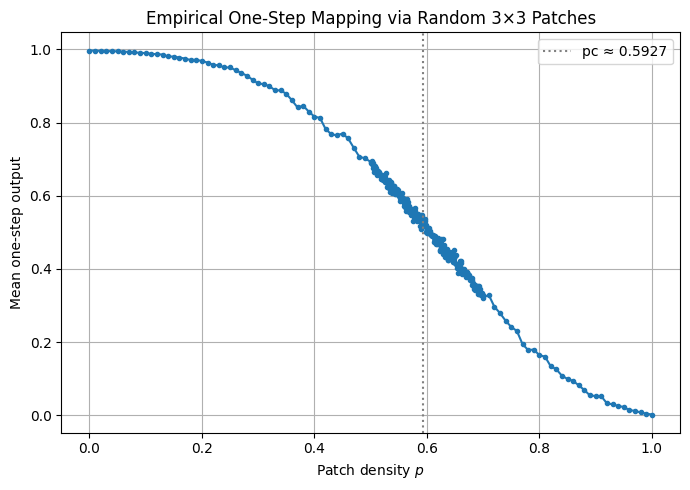

In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# ─── Assumptions ───────────────────────────────────────────────────────────────
# You have already defined/loaded:
#   - model     : your trained PercolationModel instance
#   - DIM       : patch size (should be 3)
#   - DEVICE    : torch.device('cuda' or 'cpu')
# And model.rule maps a flattened (DIM*DIM)-vector → scalar.

model.eval()

# ─── Grid of p values ────────────────────────────────────────────────────────────
ps_coarse = np.linspace(0.0, 1.0, 101)
ps_fine   = np.linspace(0.5, 0.7, 201)
ps = np.unique(np.concatenate((ps_coarse, ps_fine)))
ps.sort()

# ─── Sampling parameters ─────────────────────────────────────────────────────────
n_patches = 1000   # how many random 3×3 lattices per p

# ─── Compute one-step curve ─────────────────────────────────────────────────────
mean_outputs = []
with torch.no_grad():
    for p in ps:
        # generate (n_patches x DIM x DIM) random binary lattices
        mats = np.random.rand(n_patches, DIM, DIM) < p    # boolean
        mats = mats.astype(np.float32).reshape(n_patches, -1)  # flatten to [n,9]
        
        # to tensor
        inp = torch.from_numpy(mats).to(DEVICE)  # shape [n_patches, 9]
        
        # rule output
        outs = model.rule(inp).cpu().numpy().flatten()  # [n_patches]
        
        mean_outputs.append(outs.mean())

# ─── Plot ───────────────────────────────────────────────────────────────────────
plt.figure(figsize=(7,5))
plt.plot(ps, mean_outputs, '-o', markersize=3)
plt.axvline(0.5927, color='gray', linestyle=':', label='pc ≈ 0.5927')
plt.xlabel("Patch density $p$")
plt.ylabel("Mean one-step output")
plt.title("Empirical One‐Step Mapping via Random 3×3 Patches")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(f'{DIM}x{DIM}_one_step_NFS.pdf')
plt.show()
